Install NumPyro by running:
`$ pip install --upgrade numpyro`

In [1]:
from functools import partial

# Import regular numpy in additional to JAX's
import numpy
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb

In [2]:
# Compute on a CPU using 2 cores
numpyro.set_platform("cpu")
numpyro.set_host_device_count(2)

# Make plots larger by default
plt.rc("figure", dpi=100)

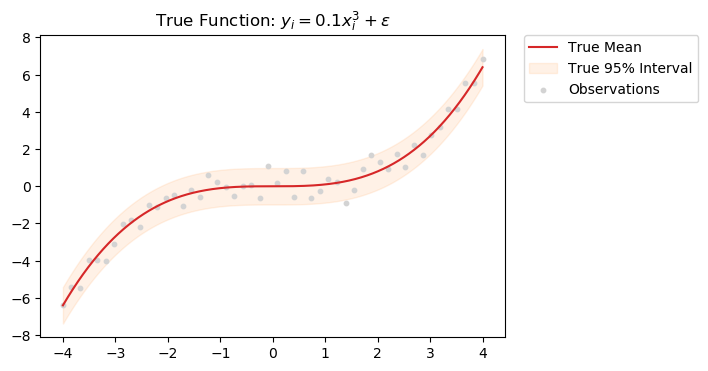

In [3]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x ** 3, scale=0.5)
func.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

data_points = [
    {"n_points": 50, "xlim": [-4, 4]},
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

In [4]:
# Observations
X = df[["x"]].values
Y = df[["y"]].values
X_test = numpy.linspace(X.min(), X.max(), num=1000)[:, np.newaxis]

# Number of hidden layers
hidden = 1
# Width of hidden layers
width = 5
# Standard deviation of the prior
sigma = 2.0
# Standard deviation of the likelihood
noise = 0.5

# Instantiate the model with prior standard deviation and likelihood noise
model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

In [5]:
%%time
# NUTS parameters
num_chains = 2
num_samples = 2000
num_warmup = 2000

# Run the No-U-Turn sampler. Note: sampling more than one chain in parallel doesn't show a progress bar
mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0[0,0]      0.19      2.78      0.40     -4.04      4.13    253.60      1.00
   b0[0,1]      0.12      2.73      0.29     -4.04      3.99    338.16      1.00
   b0[0,2]     -0.11      2.80     -0.18     -4.13      3.94    311.59      1.00
   b0[0,3]     -0.09      2.79     -0.13     -4.02      4.01    249.81      1.01
   b0[0,4]      0.12      2.75      0.26     -3.97      4.00    358.39      1.00
        b1      0.31      1.30      0.35     -1.78      2.51   1590.37      1.00
   w0[0,0]      0.02      1.25      0.02     -1.70      1.97    469.70      1.00
   w0[0,1]     -0.06      1.32     -0.16     -2.14      1.89    550.53      1.00
   w0[0,2]      0.02      1.24     -0.02     -1.68      1.91    433.25      1.00
   w0[0,3]      0.04      1.17      0.08     -1.62      1.73    350.84      1.01
   w0[0,4]     -0.03      1.27     -0.09     -1.86      1.90    365.56      1.00
   w1[0,0]      0.02      2

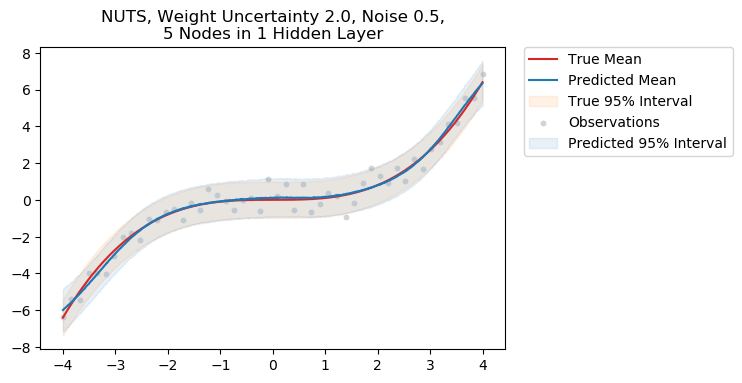

In [6]:
# Generate the posterior predictive and plot the results
posterior_predictive = simulate_posterior_predictive(model, mcmc, X_test, seed=1)
plot_posterior_predictive(
    X_test,
    posterior_predictive,
    func=func,
    df=df,
    title=f"NUTS, Weight Uncertainty {sigma}, Noise {noise},\n" f"{width} Nodes in {hidden} Hidden Layer",
)